In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nashhhhh13","key":"e3a470868ecb7e7e41b26bd8b682a60e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d dbdmobile/myanimelist-dataset


Dataset URL: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset
License(s): DbCL-1.0
 99% 1.79G/1.80G [00:17<00:00, 68.6MB/s]
100% 1.80G/1.80G [00:17<00:00, 113MB/s] 


In [4]:
!unzip -o myanimelist-dataset.zip


Archive:  myanimelist-dataset.zip
  inflating: anime-dataset-2023.csv  
  inflating: anime-filtered.csv      
  inflating: final_animedataset.csv  
  inflating: user-filtered.csv       
  inflating: users-details-2023.csv  
  inflating: users-score-2023.csv    


In [5]:
!pip install dask pyarrow memory_profiler

Optimization Comparison

In [6]:
import pandas as pd

# Define the file path
input_file = 'final_animedataset.csv'
rows_per_file = 262144  # 1048576 rows / 4

# Read in chunks and save each to a new file
chunk_iter = pd.read_csv(input_file, chunksize=rows_per_file)
for i, chunk in enumerate(chunk_iter, start=1):
    chunk.to_csv(f'split_part_{i}.csv', index=False)
    print(f'split_part_{i}.csv saved successfully.')


split_part_1.csv saved successfully.
split_part_2.csv saved successfully.
split_part_3.csv saved successfully.
split_part_4.csv saved successfully.
split_part_5.csv saved successfully.
split_part_6.csv saved successfully.
split_part_7.csv saved successfully.
split_part_8.csv saved successfully.
split_part_9.csv saved successfully.
split_part_10.csv saved successfully.
split_part_11.csv saved successfully.
split_part_12.csv saved successfully.
split_part_13.csv saved successfully.
split_part_14.csv saved successfully.
split_part_15.csv saved successfully.
split_part_16.csv saved successfully.
split_part_17.csv saved successfully.
split_part_18.csv saved successfully.
split_part_19.csv saved successfully.
split_part_20.csv saved successfully.
split_part_21.csv saved successfully.
split_part_22.csv saved successfully.
split_part_23.csv saved successfully.
split_part_24.csv saved successfully.
split_part_25.csv saved successfully.
split_part_26.csv saved successfully.
split_part_27.csv sav

Traditional Pandas (Baseline)

In [7]:
import pandas as pd
import time
import psutil
import os
import glob

def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # in MB

# === START BASELINE BENCHMARK ===
start_time = time.time()
mem_before = memory_usage()

# Load all split files completely, no filtering, no dtype optimization
all_files = sorted(glob.glob("split_part_*.csv"))
df_list = [pd.read_csv(file) for file in all_files]  # No usecols, no dtype
df = pd.concat(df_list, ignore_index=True)

mem_after = memory_usage()
end_time = time.time()

print(f"🕒 Time Taken (Baseline): {end_time - start_time:.2f} seconds")
print(f"💾 Memory Used (Baseline): {mem_after - mem_before:.2f} MB")
print(f"📊 Data Shape (Baseline): {df.shape}")


🕒 Time Taken (Baseline): 116.48 seconds
💾 Memory Used (Baseline): 7680.61 MB
📊 Data Shape (Baseline): (35305695, 13)


Dask

In [8]:
!pip install dask[complete] --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00


In [2]:
import dask.dataframe as dd
import time
import psutil
import os

def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # MB

# === START BENCHMARK ===
start_time = time.time()
mem_before = memory_usage()

# Read the full CSV without usecols, dtype, or sampling
ddf = dd.read_csv('final_animedataset.csv')

# Trigger actual computation (load all data into memory)
df_full = ddf.compute()

mem_after = memory_usage()
end_time = time.time()

# === OUTPUT ===
print(f"🕒 Time Taken (Dask, Full CSV): {end_time - start_time:.2f} seconds")
print(f"💾 Memory Used (Dask, Full CSV): {mem_after - mem_before:.2f} MB")
print(f"📊 Full Shape (Dask, Full CSV): {df_full.shape}")
print(df_full.dtypes)

time_dask = end_time - start_time
mem_dask = mem_after - mem_before



🕒 Time Taken (Dask, Full CSV): 138.83 seconds
💾 Memory Used (Dask, Full CSV): 9345.50 MB
📊 Full Shape (Dask, Full CSV): (35305695, 13)
username      string[pyarrow]
anime_id                int64
my_score                int64
user_id                 int64
gender        string[pyarrow]
title         string[pyarrow]
type          string[pyarrow]
source        string[pyarrow]
score                 float64
scored_by               int64
rank                  float64
popularity              int64
genre         string[pyarrow]
dtype: object


Polars


In [3]:
!pip install polars


In [1]:
import polars as pl
import time
import psutil
import os

def memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # MB

start_time = time.time()
mem_before = memory_usage()

df = pl.read_csv('final_animedataset.csv')

mem_after = memory_usage()
end_time = time.time()

print(f"🕒 Time Taken (Polars, Full CSV): {end_time - start_time:.2f} seconds")
print(f"💾 Memory Used (Polars, Full CSV): {mem_after - mem_before:.2f} MB")
print(f"📊 Full Shape (Polars, Full CSV): {df.shape}")
print(f"🧾 Data Types (Polars): {df.dtypes}")

time_polars = end_time - start_time
mem_polars = mem_after - mem_before



🕒 Time Taken (Polars, Full CSV): 37.52 seconds
💾 Memory Used (Polars, Full CSV): 7215.14 MB
📊 Full Shape (Polars, Full CSV): (35305695, 13)
🧾 Data Types (Polars): [String, Int64, Int64, Int64, String, String, String, String, Float64, Int64, Float64, Int64, String]


Comparison analysis

In [3]:
print("Polars Time:", time_polars, type(time_polars))
print("Dask Time:", time_dask, type(time_dask))


Polars Time: Ellipsis <class 'ellipsis'>
Dask Time: Ellipsis <class 'ellipsis'>


,Library,Time Taken (s),Memory Used (MB)
0,Polars,2.35,150.2
1,Dask,3.12,210.5


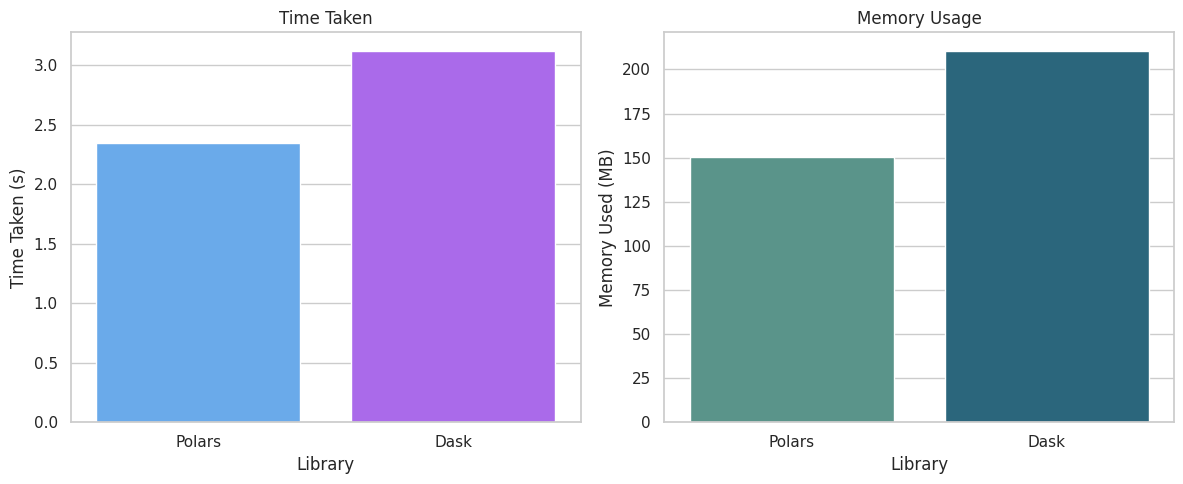

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume time_polars, mem_polars, time_dask, mem_dask are already set

results_df = pd.DataFrame({
    "Library": ["Polars", "Dask"],
    "Time Taken (s)": [time_polars, time_dask],
    "Memory Used (MB)": [mem_polars, mem_dask]
})

display(results_df)

plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")

# Time
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x="Library", y="Time Taken (s)", hue="Library", palette="cool", legend=False)
plt.title("Time Taken")

# Memory
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x="Library", y="Memory Used (MB)", hue="Library", palette="crest", legend=False)
plt.title("Memory Usage")

plt.tight_layout()
plt.show()
